In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(stringr)
library(Sierra)
library(presto)
library(ggplot2)
library(msigdbr)
library(fgsea)
library(Seurat)
library(tidyverse)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
"replacing previous import 'GenomicRanges::union' by 'dplyr::union' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::intersect' by 'dplyr::intersect' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::setdiff' by 'dplyr::setdiff' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::tail' by 'utils::tail' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::head' by 'utils::head' when loading 'Sierra'"
Loading required package: Rcpp

Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


Registered S3 method overwritten by 'cli':
  method     f

In [2]:
setwd('/home/aiden/codes/APA_stuff/post_qual/APA')

In [9]:
ge_so <- readRDS('rdata/ge_all_in_so.rds')

In [12]:
peak.annotations <- read.table("/data/APAproject//post_qual/data/Alexandra_Grubman/Sierra_outs_2/Alexandra_Sierra_for_annotations.txt", 
                               header = TRUE,
                               sep = "\t",
                               row.names = 1,
                               stringsAsFactors = FALSE)
head(peak.annotations)

,seqnames,start,end,width,strand,gene_id,UTR3,UTR5,intron,exon,CDS,pA_motif,pA_stretch,pT_stretch,Junctions
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<chr>
RALBP1:chr18:9475392-9517266:1,chr18,9475392,9517266,41875,+,"RALBP1,AP005432.1",,YES,YES,YES,YES,FALSE,FALSE,FALSE,across-junctions
FDFT1:chr8:11831598-11839273:1,chr8,11831598,11839273,7676,+,FDFT1,YES,,,,,FALSE,FALSE,FALSE,across-junctions
PCM1:chr8:18014452-18028219:1,chr8,18014452,18028219,13768,+,PCM1,YES,,,,,FALSE,FALSE,FALSE,across-junctions
ANKRD12:chr18:9221796-9254890:1,chr18,9221796,9254890,33095,+,ANKRD12,YES,,,,,FALSE,FALSE,FALSE,across-junctions
SUPT20H:chr13:37009312-37012363:-1,chr13,37009312,37012363,3052,-,SUPT20H,YES,,,,,FALSE,FALSE,FALSE,across-junctions
C11orf58:chr11:16752670-16755538:1,chr11,16752670,16755538,2869,+,C11orf58,YES,,,,,FALSE,FALSE,FALSE,across-junctions


In [14]:
APA.peak.annotations <- peak.annotations %>% filter(UTR3=='YES')
dim(APA.peak.annotations)

[1] 28532    15

In [30]:
dim(unique(APA.peak.annotations['gene_id']))

[1] 12497     1

In [15]:
peak.counts_2 <- ReadPeakCounts(data.dir = "/data/APAproject/post_qual/data/Alexandra_Grubman/Sierra_outs_2/Alexandra_Sierra_aggregate")
peaks_ge.so <- PeakSeuratFromTransfer(peak.data = peak.counts_2, 
                                       genes.seurat = ge_so, 
                                       annot.info = APA.peak.annotations, 
                                       min.cells = 0, min.peaks = 200)

[1] "Creating Seurat object with 27598 peaks and 13214 cells"


Warning message:
"The following arguments are not used: row.names"


[1] "Preparing feature table for DEXSeq"
[1] "t-SNE coordinates added"
[1] "UMAP coordinates added"


In [18]:
peaks_ge.so <- AddMetaData(peaks_ge.so, metadata = ge_so@meta.data)

In [3]:
process_pca <- function (so, n_features){
    so <- NormalizeData(so, normalization.method = "LogNormalize",scale.factor = 10000)
    so <- FindVariableFeatures(object = so,selection.method = "vst", nfeatures = n_features)
    so <- ScaleData(so, features = rownames(so))
    so <- RunPCA(so, features = VariableFeatures(object = so))
    return(so)
}
peaks_so <- process_pca(peaks_ge.so,2000)

An object of class Seurat 
113733 features across 13214 samples within 1 assay 
Active assay: RNA (113733 features, 1000 variable features)
 2 dimensional reductions calculated: pca, umap

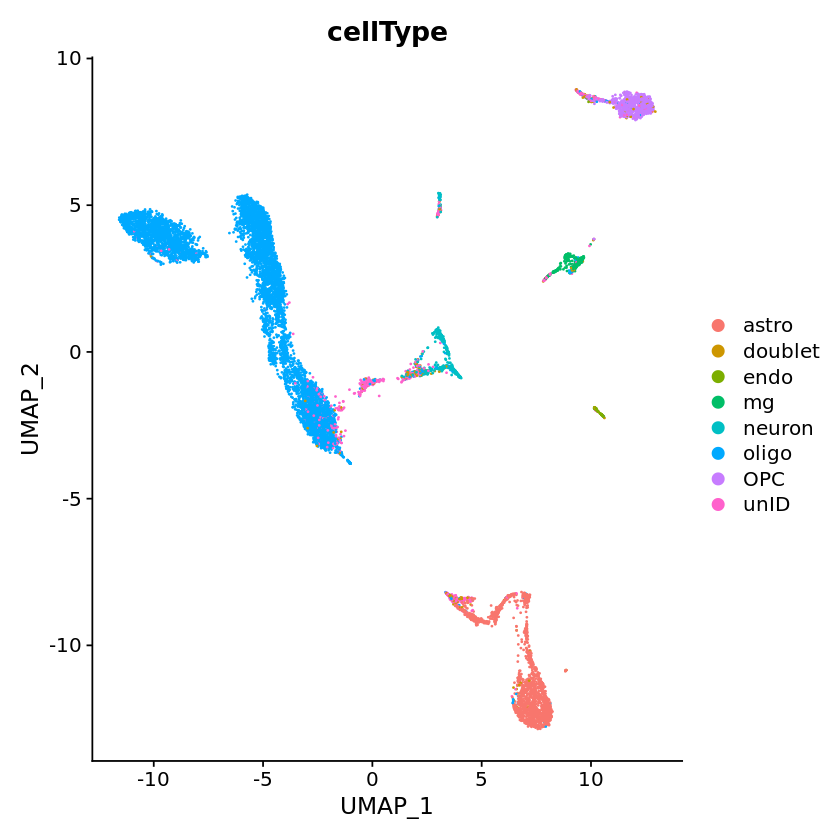

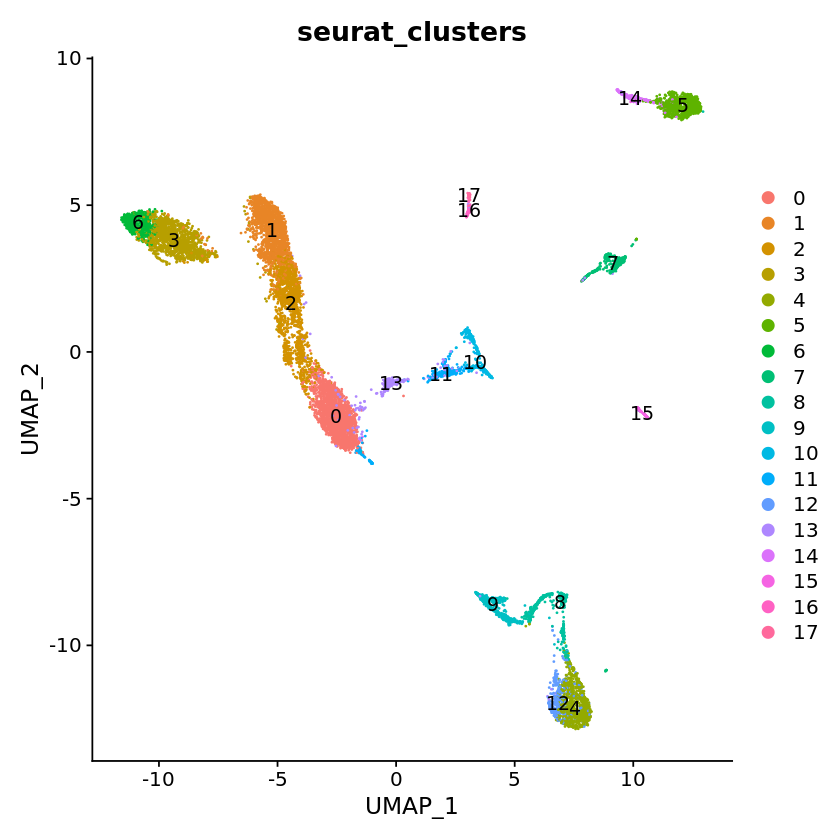

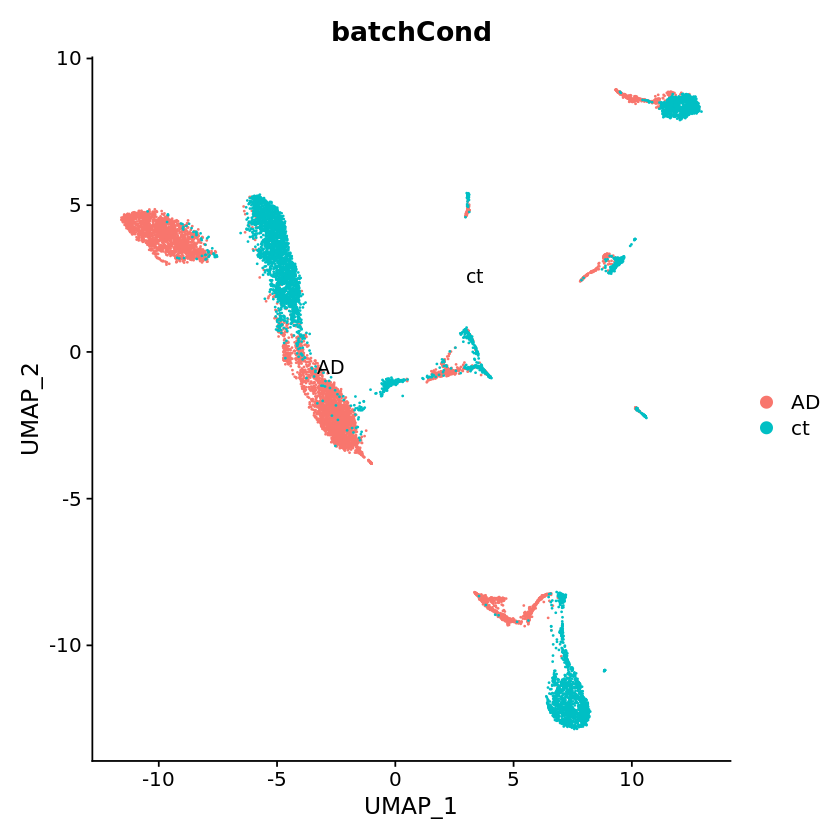

In [70]:
DimPlot(peaks_ge.so, reduction='umap', group.by='cellType')
DimPlot(peaks_ge.so, reduction='umap', group.by='seurat_clusters', label = T)
DimPlot(peaks_ge.so, reduction='umap', group.by='batchCond', label = T)

In [33]:
peaks_ge.so <- SetIdent(peaks_ge.so, value = peaks_so$seurat_clusters)

In [41]:
res.table = DUTest(peaks_ge.so, 
                   population.1 = "3", 
                   exp.thresh = 0.1)

[1] "716 expressed peaks in feature types UTR3, exon"
[1] "111 genes detected with multiple peak sites expressed"
[1] "259 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in vst(exp(alleffects), object):
"Dispersion function not parametric, applying log2(x+ 1) instead of vst...
"


In [42]:
res.table

,gene_name,genomic_feature(s),population1_pct,population2_pct,pvalue,padj,Log2_fold_change
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MBP:chr18:76978827-76979136:-1,MBP,UTR3,0.50880759,0.52307827,2.562677e-165,6.637332e-163,-0.9247608
MBP:chr18:77016135-77016574:-1,MBP,UTR3,0.50203252,0.20137859,9.564228e-111,1.238567e-108,0.8358091
GPM6B:chrX:13773938-13774416:-1,GPM6B,UTR3,0.48306233,0.35468109,5.309880e-43,4.584197e-41,0.4457306
ATP1B1:chr1:169132262-169132722:1,ATP1B1,UTR3,0.13821138,0.18227031,4.280267e-36,2.771473e-34,-1.1799575
MBP:chr18:76987535-76988030:-1,MBP,UTR3,0.28048780,0.11273013,9.684721e-32,5.016686e-30,0.7368309
TMEM144:chr4:158254781-158255369:1,TMEM144,UTR3,0.15989160,0.12503272,2.927333e-31,1.263632e-29,-0.8910761
SPP1:chr4:87982498-87982950:1,SPP1,UTR3,0.33672087,0.11866329,1.718315e-30,5.563045e-29,0.6473010
CIRBP:chr19:1272756-1273194:1,CIRBP,UTR3,0.17682927,0.11464968,2.380369e-30,6.850172e-29,1.0389481
GPM6B:chrX:13770939-13771407:-1,GPM6B,UTR3,0.16734417,0.22851409,6.192203e-28,1.603781e-26,-0.7942493


In [43]:
overall_DUT_result_top <- subset(res.table, abs(Log2_fold_change) > 1)
overall_DUT_result_top

,gene_name,genomic_feature(s),population1_pct,population2_pct,pvalue,padj,Log2_fold_change
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATP1B1:chr1:169132262-169132722:1,ATP1B1,UTR3,0.1382114,0.1822703,4.280267e-36,2.771473e-34,-1.179957
CIRBP:chr19:1272756-1273194:1,CIRBP,UTR3,0.1768293,0.1146497,2.380369e-30,6.850172e-29,1.038948


[1] "ATP1B1:chr1:169132262-169132722:1" "ATP1B1:chr1:169131132-169131864:1"
[3] "ATP1B1:chr1:169127284-169131880:1" "ATP1B1:chr1:169129904-169131879:1"


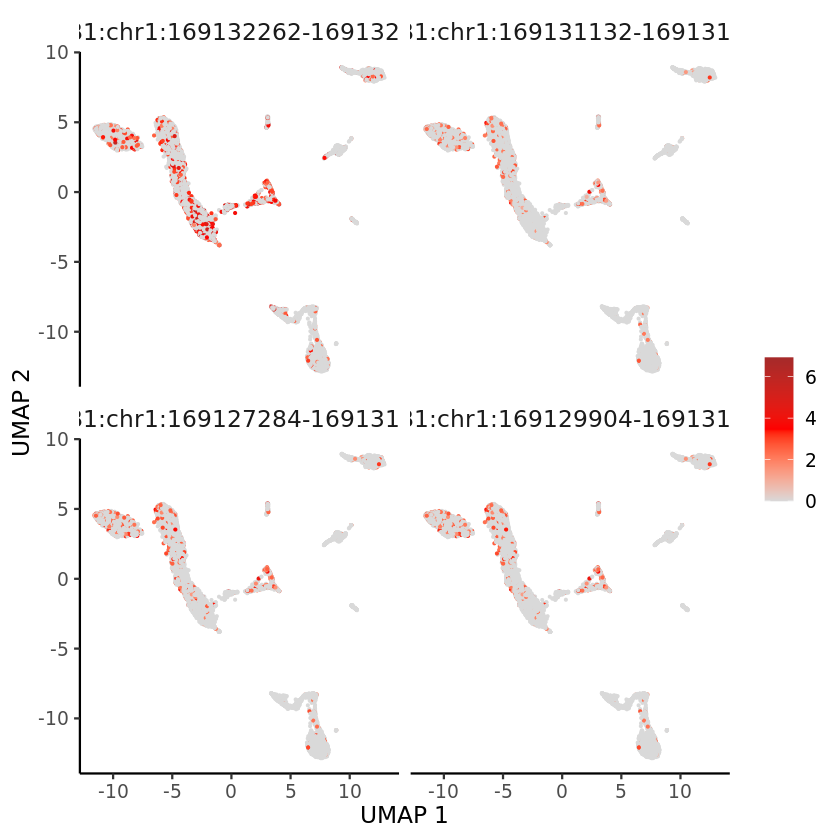

In [45]:
peaks.to.plot <- rownames(subset(res.table, gene_name == "ATP1B1"))
print(peaks.to.plot)
PlotRelativeExpressionUMAP(peaks_ge.so, peaks.to.plot = peaks.to.plot)

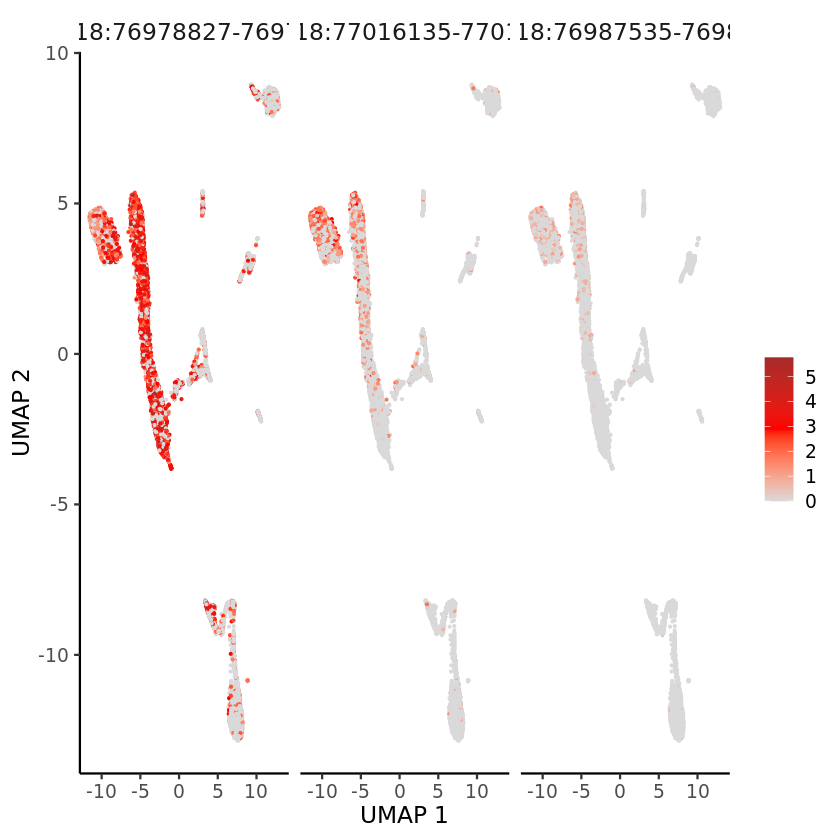

In [40]:
PlotRelativeExpressionUMAP(peaks_ge.so, peaks.to.plot = peaks.to.plot)

In [46]:
reference.file <- '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes//genes.gtf'
gtf_gr <- rtracklayer::import(reference.file)
gtf_TxDb <- GenomicFeatures::makeTxDbFromGFF(reference.file, format="gtf")
res.table <- DetectUTRLengthShift(peaks.object = peaks_ge.so, 
                                  gtf_gr = gtf_gr,
                                  gtf_TxDb = gtf_TxDb,
                                  population.1 = "1", 
                                  population.2 = "2")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK



[1] "662 expressed peaks in feature types UTR3"
[1] "632 peaks after filtering out A-rich annotations"
[1] "97 genes detected with multiple peak sites expressed"
[1] "220 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Detecting shifts in 3'UTR length usage"


Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 0.00182053260932526"


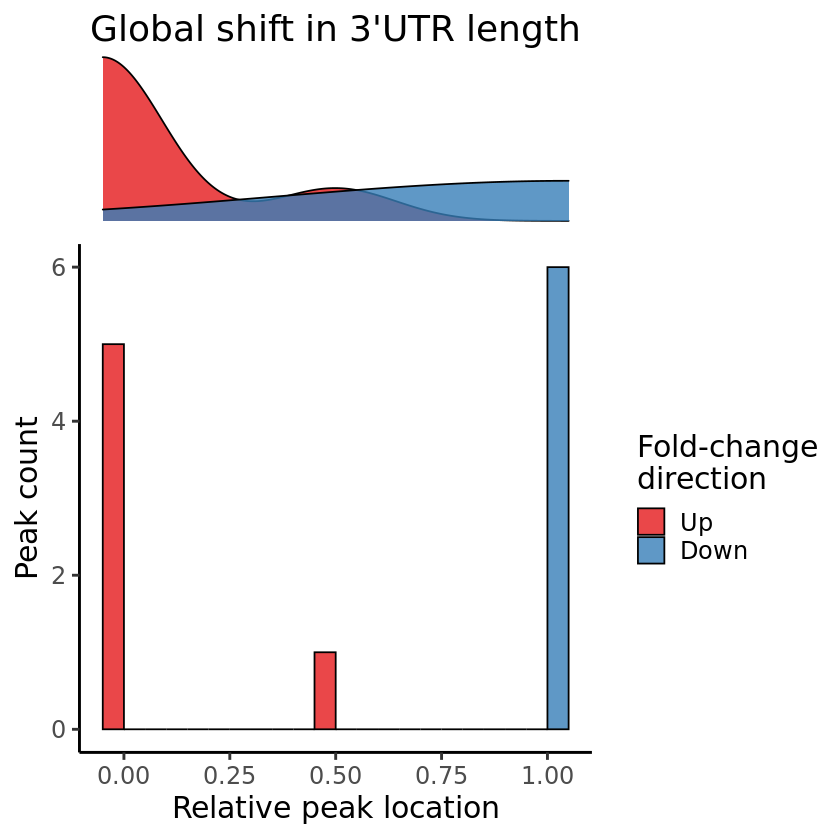

In [47]:
PlotUTRLengthShift(res.table)

In [48]:
res.table

,genomic_feature(s),population1_pct,population2_pct,pvalue,padj,Log2_fold_change,SiteLocation,NumSites,FC_direction
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
PLP1:chrX:103790651-103791119:1,UTR3,0.1823600,0.12376934,2.050000e-04,3.605862e-03,0.4552030,1,3,Up
SPP1:chr4:87982498-87982950:1,UTR3,0.1150179,0.08931083,2.092661e-03,2.423081e-02,0.4159452,1,2,Up
ATP1B1:chr1:169132262-169132722:1,UTR3,0.1334923,0.18073136,1.426869e-04,2.853737e-03,-0.6862211,4,4,Down
SRSF5:chr14:69771515-69772005:1,UTR3,0.1686532,0.18284107,2.753269e-04,4.326566e-03,-0.3992344,3,3,Down
SAT1:chrX:23785784-23786226:1,UTR3,0.1853397,0.15049226,4.014648e-03,4.416113e-02,-0.2516797,2,2,Down
SLC1A2:chr11:35260778-35265869:-1,UTR3,0.1495828,0.06751055,5.927283e-21,6.520011e-19,1.0790615,1,2,Up
MBP:chr18:76987535-76988030:-1,UTR3,0.1662694,0.08720113,1.083544e-11,7.945990e-10,0.5737941,1,2,Up
AMER2:chr13:25168742-25169702:-1,UTR3,0.1209774,0.07665260,5.390360e-05,1.277314e-03,0.3086259,2,3,Up
AMER2:chr13:25169019-25169589:-1,UTR3,0.1066746,0.06540084,5.805973e-05,1.277314e-03,0.3743868,1,3,Up


[1] "839 expressed peaks in feature types UTR3"
[1] "814 peaks after filtering out A-rich annotations"
[1] "102 genes detected with multiple peak sites expressed"
[1] "224 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in vst(exp(alleffects), object):
"Dispersion function not parametric, applying log2(x+ 1) instead of vst...
"


[1] "Detecting shifts in 3'UTR length usage"


Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 0.00724032264228571"


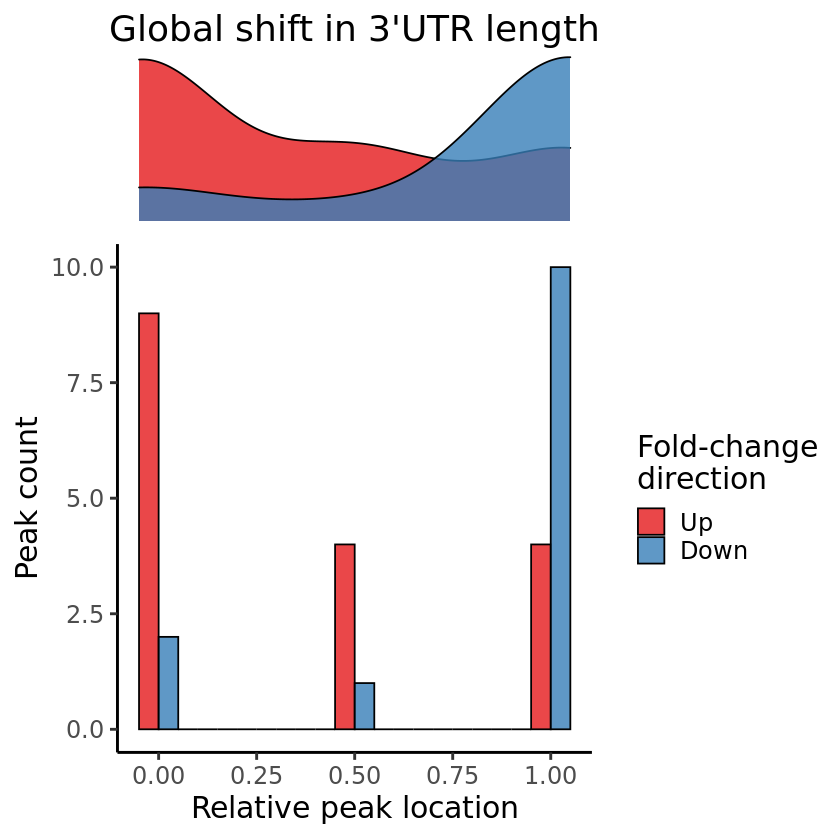

In [52]:
res.table <- DetectUTRLengthShift(peaks.object = peaks_ge.so, 
                                  gtf_gr = gtf_gr,
                                  gtf_TxDb = gtf_TxDb,
                                  population.1 = "2", 
                                  population.2 = "0")
PlotUTRLengthShift(res.table)

[1] "882 expressed peaks in feature types UTR3"
[1] "856 peaks after filtering out A-rich annotations"
[1] "113 genes detected with multiple peak sites expressed"
[1] "266 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Detecting shifts in 3'UTR length usage"


Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 6.81451004973296e-06"


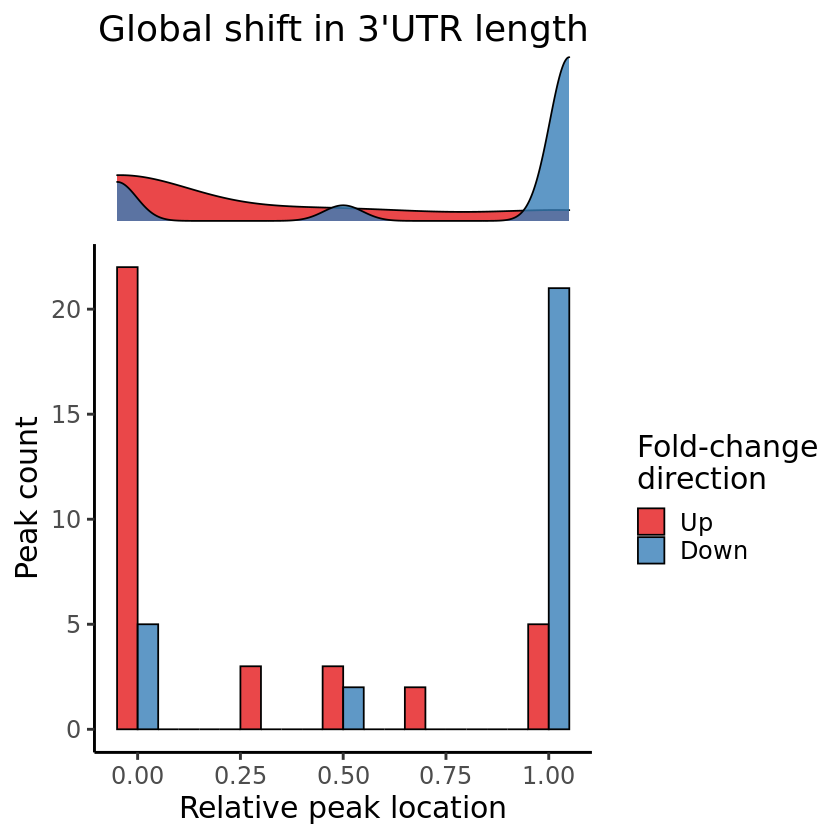

In [53]:
res.table <- DetectUTRLengthShift(peaks.object = peaks_ge.so, 
                                  gtf_gr = gtf_gr,
                                  gtf_TxDb = gtf_TxDb,
                                  population.1 = "3", 
                                  population.2 = "0")
PlotUTRLengthShift(res.table)

In [55]:
res.table <- DetectUTRLengthShift(peaks.object = peaks_ge.so, 
                                  gtf_gr = gtf_gr,
                                  gtf_TxDb = gtf_TxDb,
                                  population.1 = "6", 
                                  population.2 = "3")
PlotUTRLengthShift(res.table)

[1] "563 expressed peaks in feature types UTR3"
[1] "540 peaks after filtering out A-rich annotations"
[1] "88 genes detected with multiple peak sites expressed"
[1] "208 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in vst(exp(alleffects), object):
"Dispersion function not parametric, applying log2(x+ 1) instead of vst...
"


[1] "No DU peaks identified"


ERROR: Error in subset.default(results.table, FC_direction == "Up"): object 'FC_direction' not found


[1] "882 expressed peaks in feature types UTR3"
[1] "122 genes detected with multiple peak sites expressed"
[1] "287 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Filtering for alternative transcript usage"
[1] "62 peaks detected as representing alternative transcript usage"


,gene_name,genomic_feature(s),population1_pct,population2_pct,pvalue,padj,Log2_fold_change,Transcript_name
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
MBP:chr18:76978827-76979136:-1,MBP,UTR3,0.50880759,0.72895792,0.000000e+00,0.000000e+00,-1.3804087,ENST00000382582;ENST00000355994;ENST00000490319;ENST00000585201;ENST00000397875;ENST00000397866;ENST00000397865
MBP:chr18:77016135-77016574:-1,MBP,UTR3,0.50203252,0.05260521,4.194039e-247,6.018446e-245,3.3651595,ENST00000382582;ENST00000355994;ENST00000397875;ENST00000397866;ENST00000397865;ENST00000527041;ENST00000359645;ENST00000528160;ENST00000577755;ENST00000527975;ENST00000397869;ENST00000354542;ENST00000531144;ENST00000583474;ENST00000533278;ENST00000526111;ENST00000580402;ENST00000579129;ENST00000578193;ENST00000397868;ENST00000581179;ENST00000580473;ENST00000582282;ENST00000473302;ENST00000483025;ENST00000493623;ENST00000585216;ENST00000484548;ENST00000578873;ENST00000467108;ENST00000459948;ENST00000482445;ENST00000498683;ENST00000583266;ENST00000397863;ENST00000397860
MBP:chr18:76987535-76988030:-1,MBP,UTR3,0.28048780,0.02104208,3.379581e-103,3.233133e-101,3.4618641,ENST00000382582;ENST00000355994;ENST00000490319;ENST00000585201;ENST00000397875;ENST00000397866;ENST00000397865;ENST00000527041;ENST00000359645;ENST00000528160;ENST00000577755;ENST00000527975;ENST00000397869;ENST00000354542;ENST00000531144;ENST00000583474;ENST00000533278;ENST00000526111;ENST00000580402;ENST00000579129;ENST00000578193;ENST00000397868;ENST00000447114;ENST00000581179;ENST00000580473;ENST00000582282;ENST00000473302;ENST00000483025;ENST00000493623;ENST00000585216;ENST00000484548
GPM6B:chrX:13773938-13774416:-1,GPM6B,UTR3,0.48306233,0.34318637,1.135686e-90,8.148546e-89,1.1027680,ENST00000316715;ENST00000454189;ENST00000493677;ENST00000472735;ENST00000355135;ENST00000356942;ENST00000398361
KIAA0930:chr22:45195683-45196445:-1,KIAA0930,UTR3,0.19444444,0.34418838,2.656688e-90,1.524939e-88,-0.9542171,ENST00000336156;ENST00000423262;ENST00000251993;ENST00000391627;ENST00000488038
KIAA0930:chr22:45211263-45212279:-1,KIAA0930,UTR3,0.20121951,0.03857715,9.028343e-89,4.318558e-87,2.6070811,ENST00000336156;ENST00000251993;ENST00000391627;ENST00000488038;ENST00000440039;ENST00000414854;ENST00000424508;ENST00000486640;ENST00000417906;ENST00000496226;ENST00000492273
PTMA:chr2:231713061-231713541:1,PTMA,UTR3,0.40650407,0.41633267,4.873548e-55,1.554120e-53,-0.6347043,ENST00000448874;ENST00000409321;ENST00000409115;ENST00000341369;ENST00000481928;ENST00000409683;ENST00000412128
CIRBP:chr19:1272756-1273194:1,CIRBP,UTR3,0.17682927,0.02354709,5.105774e-51,1.465357e-49,2.6786817,ENST00000588030;ENST00000586472;ENST00000588090;ENST00000591935;ENST00000586548;ENST00000585913;ENST00000589710;ENST00000586773;ENST00000590704;ENST00000413636;ENST00000593093;ENST00000587896;ENST00000590347;ENST00000587169;ENST00000320936;ENST00000586636;ENST00000591055;ENST00000591376;ENST00000589235;ENST00000585914;ENST00000588344;ENST00000592234;ENST00000444172;ENST00000590188;ENST00000588917
GPM6B:chrX:13770939-13771407:-1,GPM6B,UTR3,0.16734417,0.37374749,1.169194e-42,2.796321e-41,-1.0640754,ENST00000316715


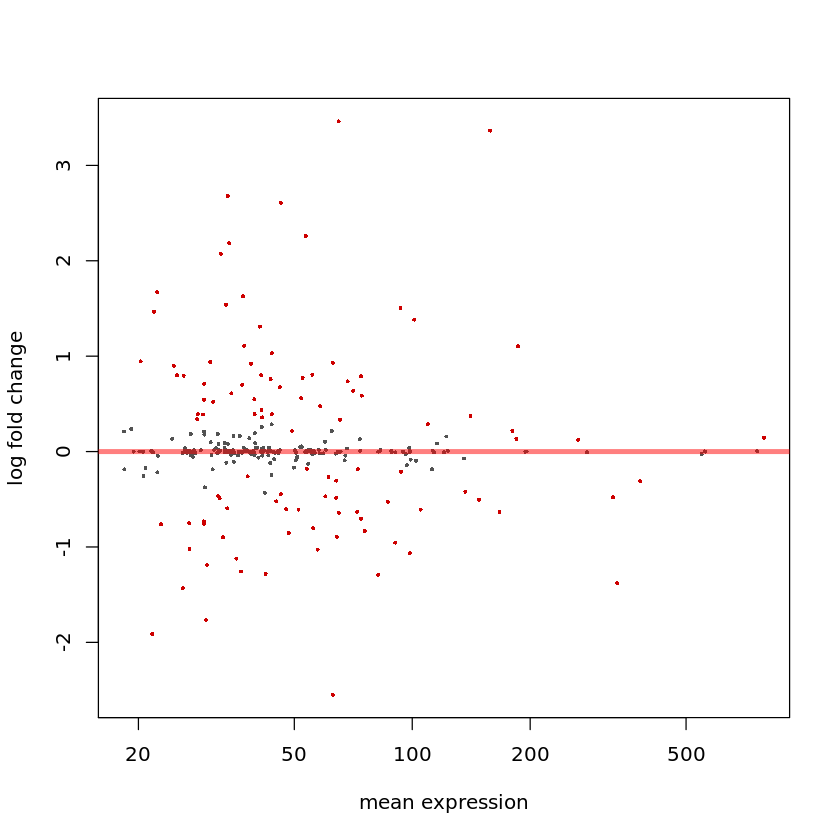

In [59]:
res.table <- DetectAEU(peaks.object = peaks_ge.so, 
                       gtf_gr = gtf_gr,
                       gtf_TxDb = gtf_TxDb,
                       do.MAPlot = T,
                       population.1 = "3", 
                       population.2 = "0")
res.table

In [60]:
res.table1 <- DetectUTRLengthShift(peaks.object = peaks_ge.so, 
                                  gtf_gr = gtf_gr,
                                  gtf_TxDb = gtf_TxDb,
                                  population.1 = "3", 
                                  population.2 = "0")
res.table1

[1] "882 expressed peaks in feature types UTR3"
[1] "856 peaks after filtering out A-rich annotations"
[1] "113 genes detected with multiple peak sites expressed"
[1] "266 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Detecting shifts in 3'UTR length usage"


,genomic_feature(s),population1_pct,population2_pct,pvalue,padj,Log2_fold_change,SiteLocation,NumSites,FC_direction
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
SPP1:chr4:87982498-87982950:1,UTR3,0.33672087,0.11322645,5.087945e-57,1.933419e-55,1.3705386,1,2,Up
CIRBP:chr19:1272756-1273194:1,UTR3,0.17682927,0.02354709,1.977591e-51,5.260392e-50,2.6776833,2,3,Up
TMEM144:chr4:158253987-158254749:1,UTR3,0.26016260,0.02705411,3.026556e-42,6.192798e-41,2.2584909,1,2,Up
PTMA:chr2:231708653-231712896:1,UTR3,0.34417344,0.08466934,4.416013e-42,8.390425e-41,1.4928002,1,3,Up
NFASC:chr1:205022412-205022822:1,UTR3,0.12804878,0.12424850,2.283373e-23,3.005310e-22,0.8029760,2,2,Up
ATP1B1:chr1:169131132-169131864:1,UTR3,0.16598916,0.03106212,3.984708e-21,4.239729e-20,0.6986011,3,4,Up
ATP1B1:chr1:169129904-169131879:1,UTR3,0.18089431,0.03657315,7.748635e-18,6.245869e-17,0.4347059,2,4,Up
ATP1B1:chr1:169127284-169131880:1,UTR3,0.18970190,0.04008016,7.691574e-18,6.245869e-17,0.3899250,1,4,Up
MOBP:chr3:39513403-39525498:1,UTR3,0.15311653,0.23747495,1.172884e-12,7.428267e-12,0.5907993,1,3,Up


In [62]:
which(startsWith(x = rownames(res.table1), 'MBP'))

[1] 38 50

In [68]:
res.table1[38,0]

MBP:chr18:76987535-76988030:-1


In [69]:
res.table1[50,0]

MBP:chr18:76978827-76979136:-1


## lets subset the Oligos and look at the APA usage in the Oligo subclusters

Warning message:
"The following arguments are not used: n_neighbors"
20:57:10 UMAP embedding parameters a = 1.929 b = 0.7915

20:57:10 Read 12937 rows and found 10 numeric columns

20:57:10 Using Annoy for neighbor search, n_neighbors = 30

20:57:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:57:12 Writing NN index file to temp file /tmp/RtmpOiKjtj/file59f94e833bab

20:57:12 Searching Annoy index using 1 thread, search_k = 3000

20:57:17 Annoy recall = 100%

20:57:19 Commencing smooth kNN distance calibration using 1 thread

20:57:22 Initializing from normalized Laplacian + noise

20:57:23 Commencing optimization for 200 epochs, with 531044 positive edges

20:57:30 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12937
Number of edges: 405354

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8489
Number of communities: 21
Elapsed time: 1 seconds


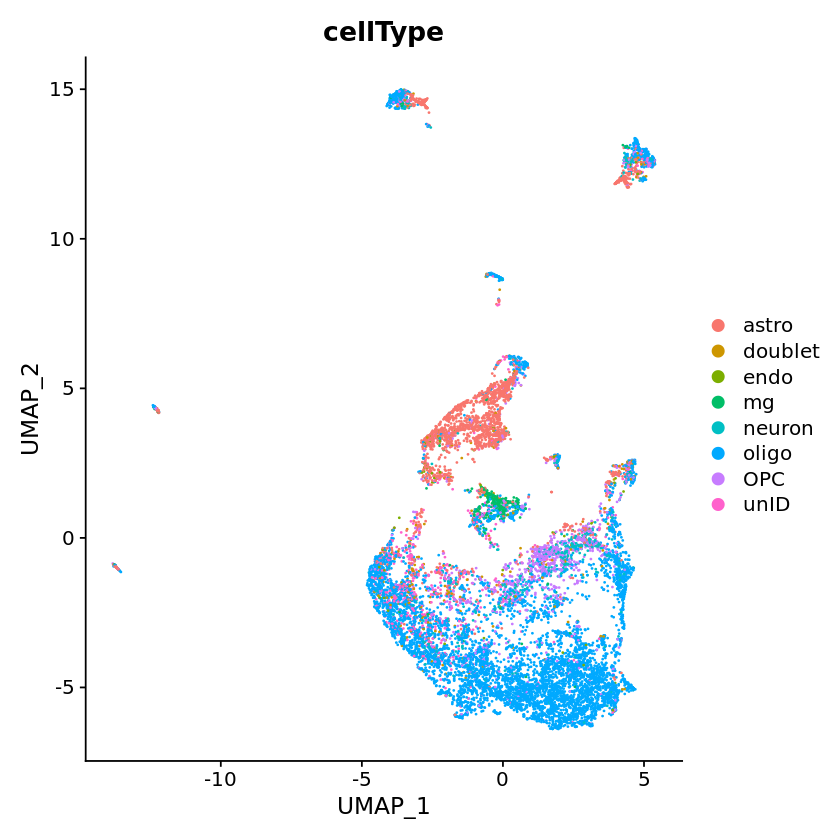

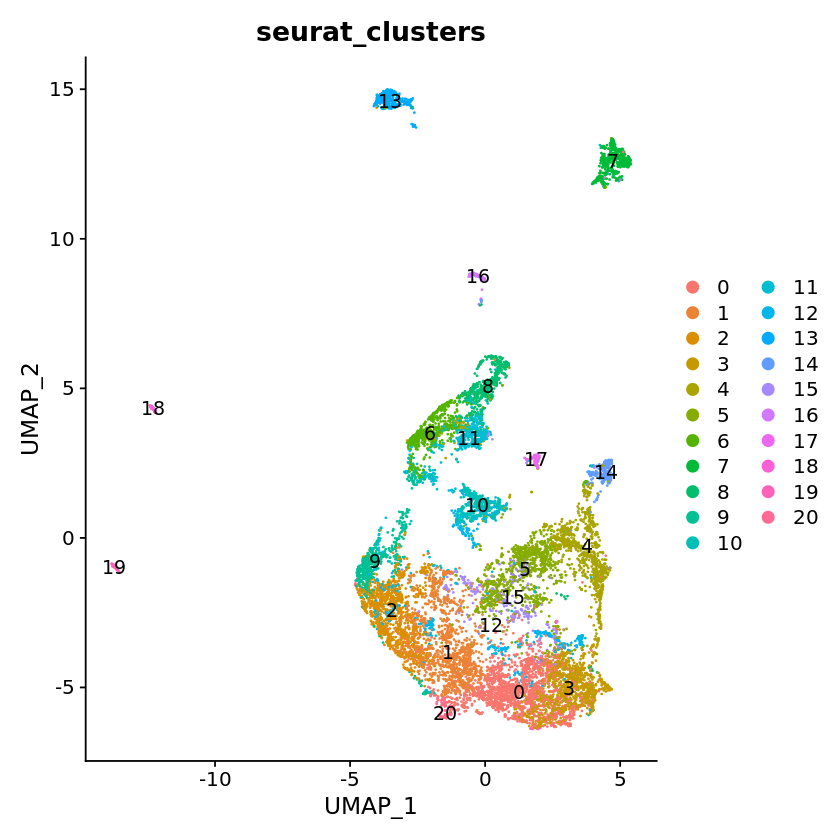

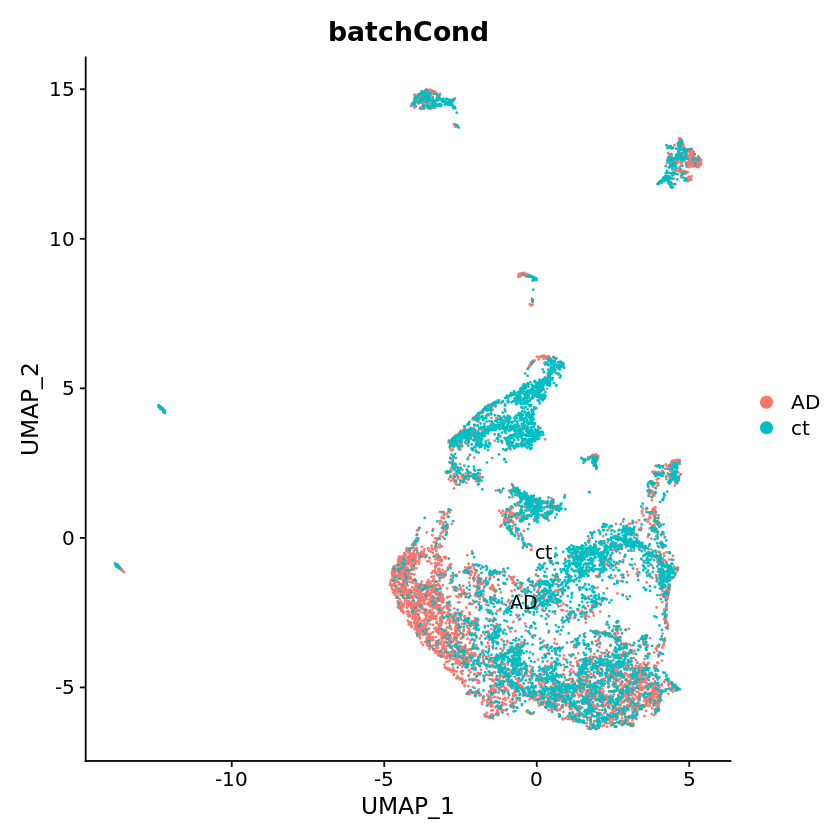

In [97]:
peaks_so <- RunUMAP(peaks_so , dims = 1:10, min.dist = 0.001,  n_neighbors = 50)    ##parameteres need to be set
peaks_so <- FindNeighbors(peaks_so, dims = 1:10)
#find cluster
peaks_so <- FindClusters(peaks_so, resolution =1)
DimPlot(peaks_so, reduction='umap', group.by='cellType')
DimPlot(peaks_so, reduction='umap', group.by='seurat_clusters', label = T)
DimPlot(peaks_so, reduction='umap', group.by='batchCond', label = T)

In [98]:
oligos_so <- subset(peaks_so, subset=cellType=='oligo')
astro_so <- subset(peaks_so, subset=cellType=='astro')

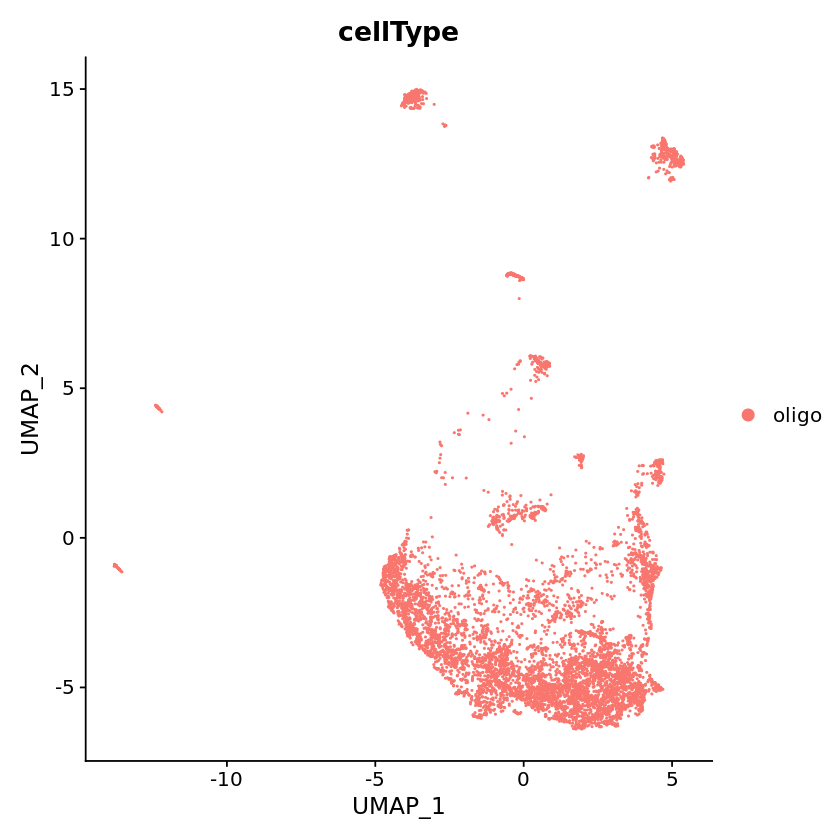

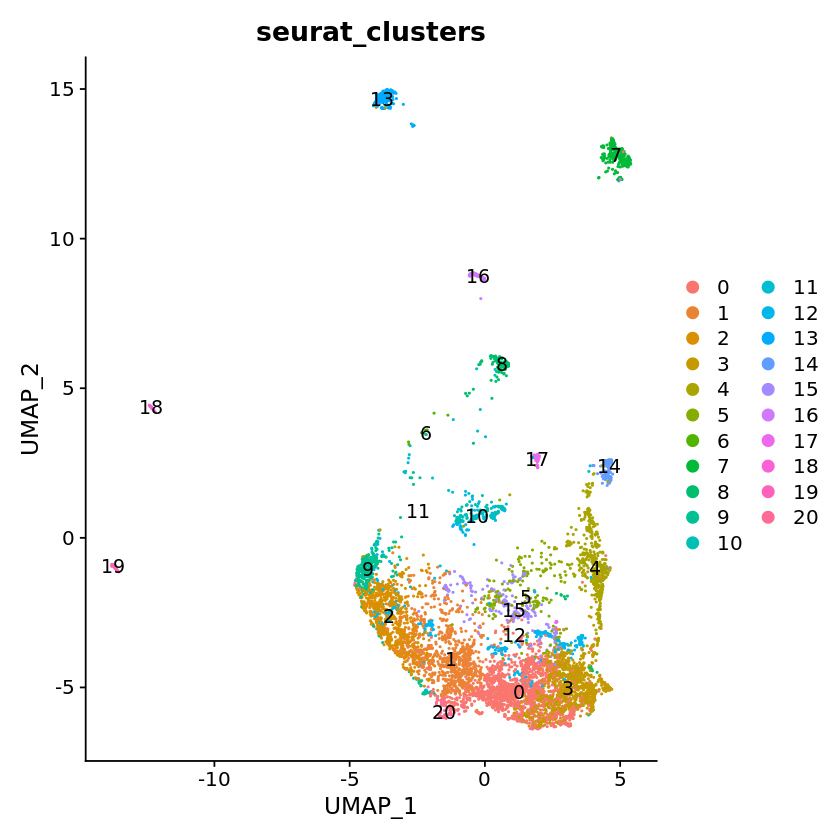

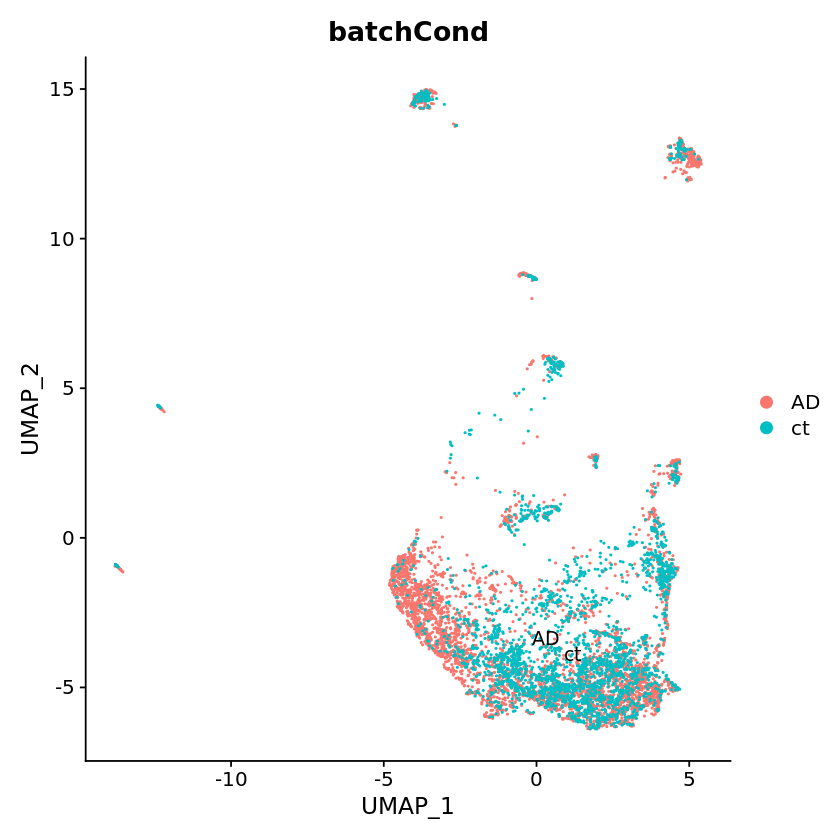

In [99]:
DimPlot(oligos_so, reduction='umap', group.by='cellType')
DimPlot(oligos_so, reduction='umap', group.by='seurat_clusters', label = T)
DimPlot(oligos_so, reduction='umap', group.by='batchCond', label = T)

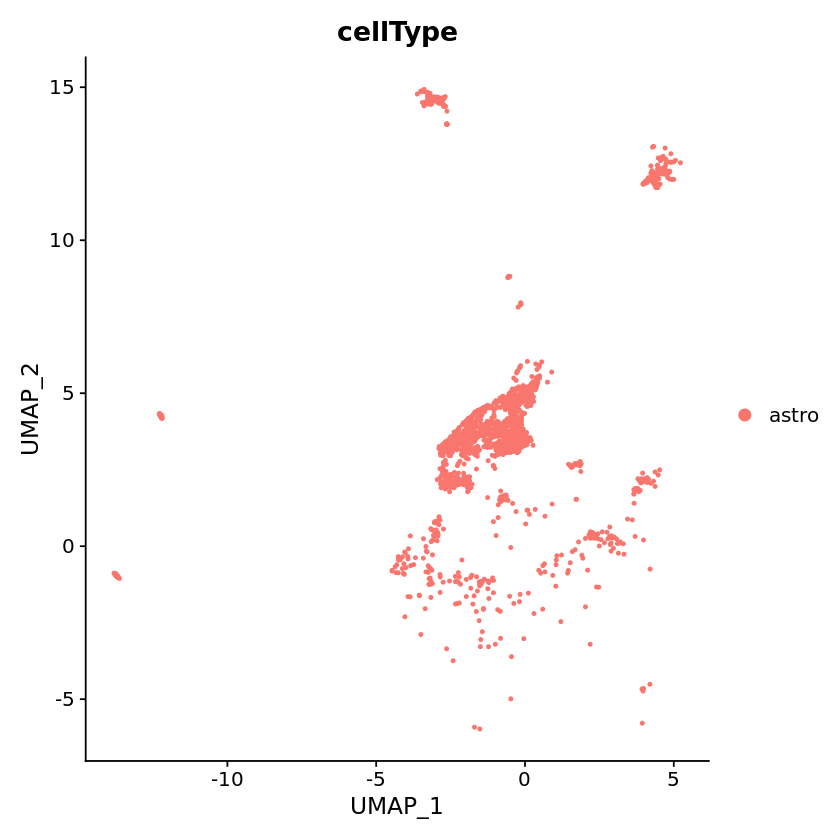

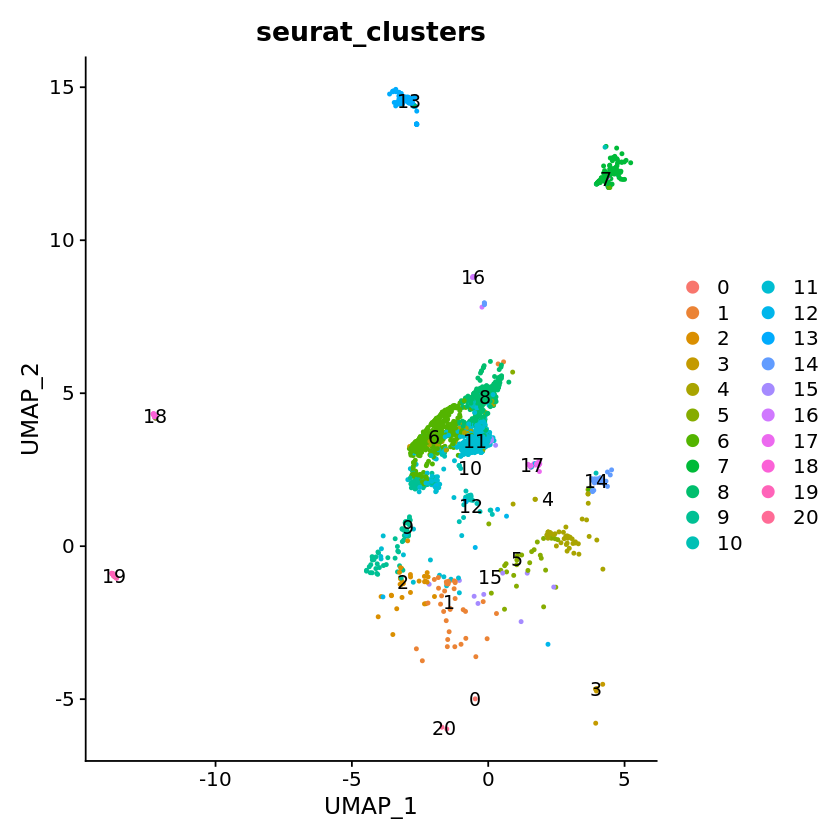

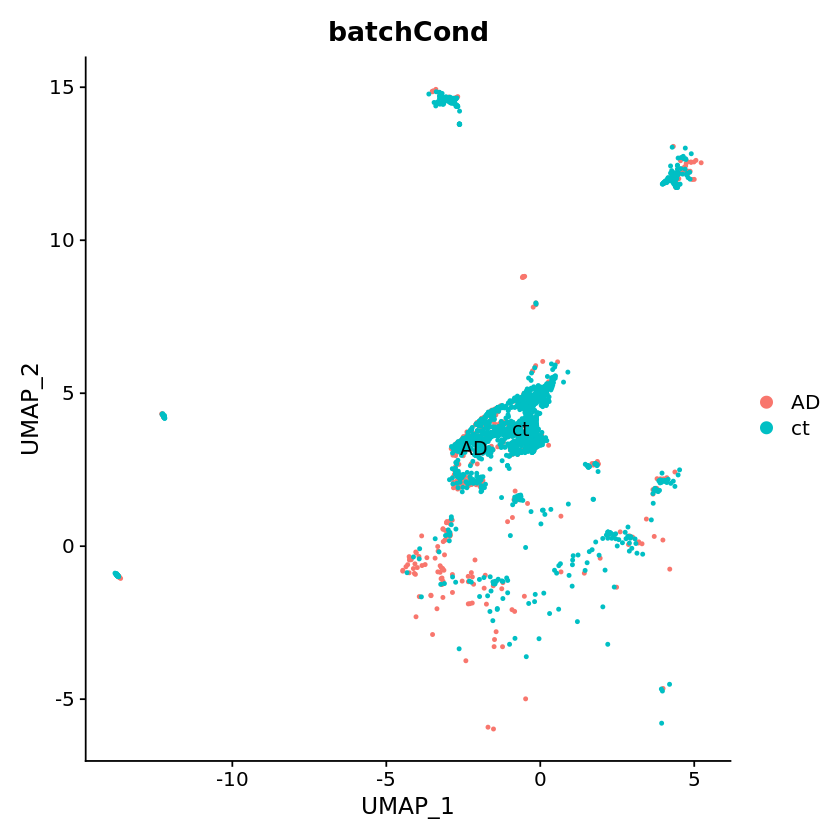

In [100]:
DimPlot(astro_so, reduction='umap', group.by='cellType')
DimPlot(astro_so, reduction='umap', group.by='seurat_clusters', label = T)
DimPlot(astro_so, reduction='umap', group.by='batchCond', label = T)

In [90]:
process_pca <- function (so, n_features){
    so <- NormalizeData(so, normalization.method = "LogNormalize",scale.factor = 10000)
    so <- FindVariableFeatures(object = so,selection.method = "vst", nfeatures = n_features)
    so <- ScaleData(so, features = rownames(so))
    so <- RunPCA(so, features = VariableFeatures(object = so))
    return(so)
}
peaks_so <- process_pca(peaks_ge.so,1000)

Centering and scaling data matrix

PC_ 1 
Positive:  TMEM144:chr4:158241447-158244551:1, PTPRK:chr6:128397264-128520309:-1, DLG1:chr3:197138244-197194524:-1, ATG4C:chr1:62833820-62864669:1, CNDP1:chr18:74559283-74562278:1, LPGAT1:chr1:211749807-211778977:-1, ATG4C:chr1:62834748-62841528:1, PXK:chr3:58397125-58409080:1, ABCA6:chr17:69134893-69136196:-1, PPP2R2A:chr8:26293626-26354587:1 
	   ABCA6:chr17:69134882-69135284:-1, ANO4:chr12:100971290-100987727:1, CDH19:chr18:66532275-66544139:-1, MAP7:chr6:136343754-136344534:-1, DOCK10:chr2:224767883-224768891:-1, MAP7:chr6:136344017-136345971:-1, PLEKHH1:chr14:67582119-67582725:1, SLCO1A2:chr12:21297221-21297641:-1, LAMP2:chrX:120438847-120442088:-1, SELENOP:chr5:42800293-42800510:-1 
	   LCORL:chr4:17845758-17909428:-1, FAM126A:chr7:22945932-22961403:-1, GNAI1:chr7:80203689-80217442:1, ATL1:chr14:50591456-50621869:1, LIMCH1:chr4:41619239-41646216:1, MAP4K5:chr14:50464048-50476305:-1, FAM177A1:chr14:35081831-35101074:1, DOCK5:chr8:25351771-

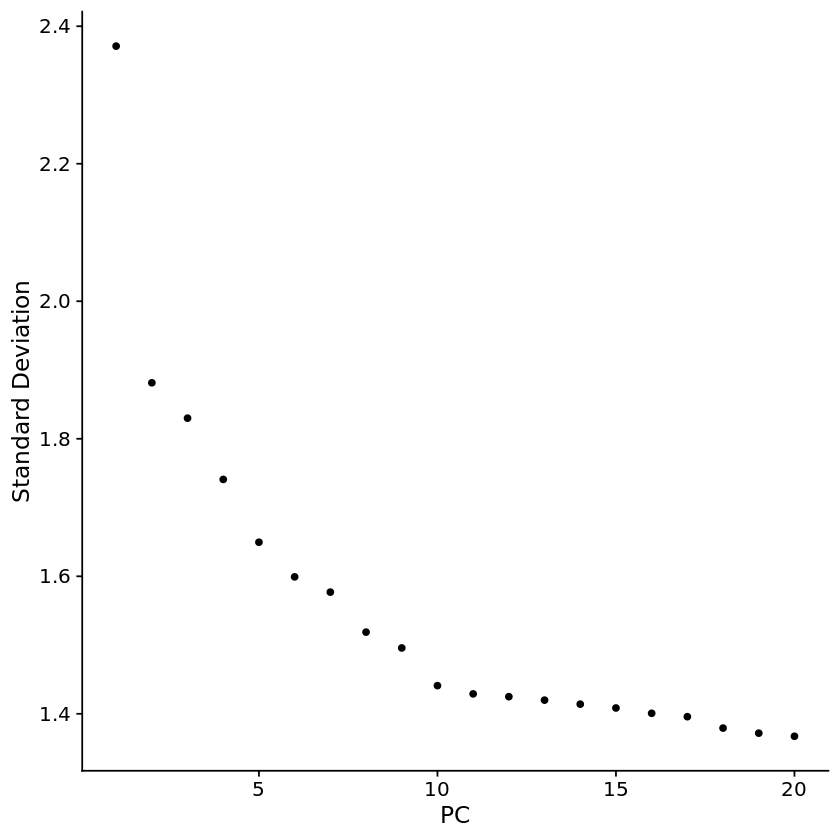

In [91]:
ElbowPlot(peaks_so)

In [102]:
table(peaks_so$cellType)


  astro doublet    endo      mg  neuron   oligo     OPC    unID 
   2157     400      93     393     648    7309    1058     879 

In [101]:
table(oligos_so$seurat_clusters)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
1573  908  817 1112  535  192    9  287  130  304  136   34  353  221  124  205 
  16   17   18   19   20 
 130   61   57   36   85 

In [103]:
### only keep the clusters with more than 100 cells
oligos_so_main_subclusters <- subset(oligos_so,subset=seurat_clusters %in% c('0','1','2','3','4','5','7',
                                                                             '8','9','10','12','14','15','16'))
oligos_so_main_subclusters$main_cluster <- factor(oligos_so_main_subclusters$seurat_clusters)
table(oligos_so_main_subclusters$main_cluster)


   0    1    2    3    4    5    7    8    9   10   12   14   15   16 
1573  908  817 1112  535  192  287  130  304  136  353  124  205  130 

In [121]:
oligos_so_main_subclusters <- process_pca(oligos_so_main_subclusters,200)
oligos_so_main_subclusters <- RunUMAP(oligos_so_main_subclusters , dims = 1:5, min.dist = 0.001,  n_neighbors = 50)    ##parameteres need to be set
oligos_so_main_subclusters <- FindNeighbors(oligos_so_main_subclusters, dims = 1:5)
#find cluster
oligos_so_main_subclusters <- FindClusters(oligos_so_main_subclusters, resolution =1)

Centering and scaling data matrix

PC_ 1 
Positive:  ASNS:chr7:97852081-97853171:-1, ASNS:chr7:97852101-97852509:-1, FXR1:chr3:180975884-180976760:1, FXR1:chr3:180970351-180976613:1, FXR1:chr3:180975818-180976148:1, NAA16:chr13:41362055-41369255:1, HSPA4:chr5:133088937-133091394:1, ZBTB20:chr3:114319126-114319590:-1, DNAJC12:chr10:67805666-67838076:-1, CXXC4:chr4:104472202-104490838:-1 
	   FAM133B:chr7:92562264-92562796:-1, CXXC4:chr4:104472164-104472566:-1, CDH19:chr18:66532275-66544139:-1, ZBTB20:chr3:114315959-114316410:-1, PLOD3:chr7:101208981-101210853:-1, PLOD3:chr7:101209344-101210256:-1, NPHP3:chr3:132686827-132687331:-1, DNAJC12:chr10:67805591-67823507:-1, NFATC3:chr16:68226487-68226944:1, CWC27:chr5:64971752-65018750:1 
	   GUF1:chr4:44689162-44689974:1, SLC38A2:chr12:46363680-46364130:-1, PIEZO2:chr18:10731265-10732261:-1, FOXO1:chr13:40558909-40559347:-1, PIEZO2:chr18:10730726-10731974:-1, SNX14:chr6:85533522-85539406:-1, ZBTB20:chr3:114328456-114328858:-1, ZBTB20:chr3:114

Warning message:
"The following arguments are not used: n_neighbors"
23:32:53 UMAP embedding parameters a = 1.929 b = 0.7915

23:32:53 Read 6806 rows and found 5 numeric columns

23:32:53 Using Annoy for neighbor search, n_neighbors = 30

23:32:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:32:54 Writing NN index file to temp file /tmp/RtmpOiKjtj/file59f93bfadbac

23:32:54 Searching Annoy index using 1 thread, search_k = 3000

23:32:57 Annoy recall = 72.79%

23:32:59 Commencing smooth kNN distance calibration using 1 thread

23:32:59 2639 smooth knn distance failures

23:33:03 Initializing from normalized Laplacian + noise

23:33:03 Commencing optimization for 500 epochs, with 275132 positive edges

23:33:24 Optimization finished

Computing nearest neighbor grap

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6806
Number of edges: 1978516

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.0433
Number of communities: 10
Elapsed time: 2 seconds


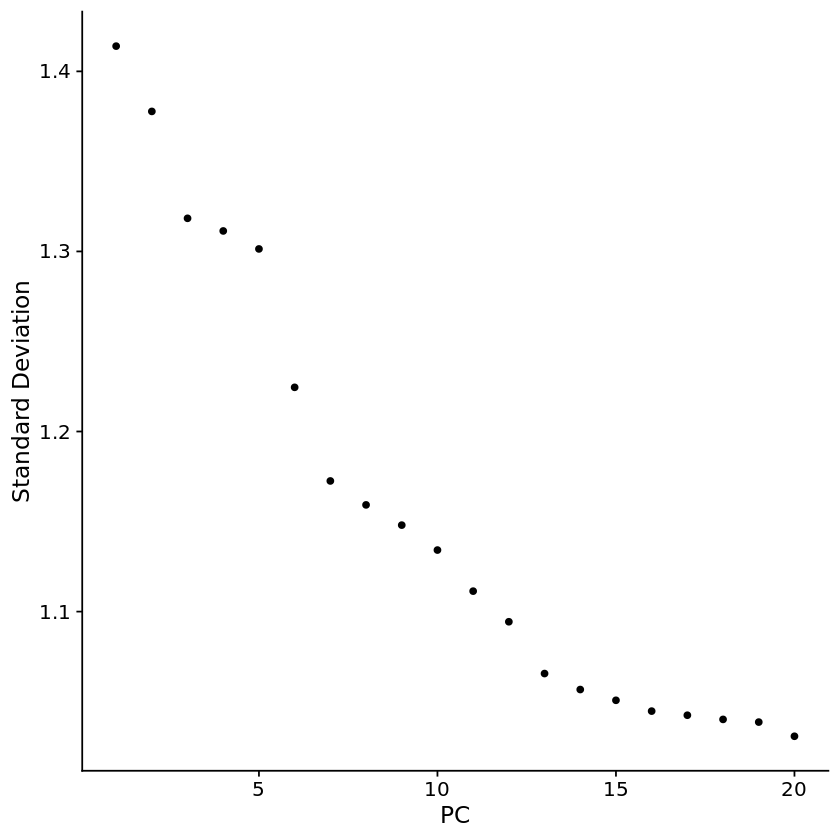

In [123]:
ElbowPlot(oligos_so_main_subclusters)

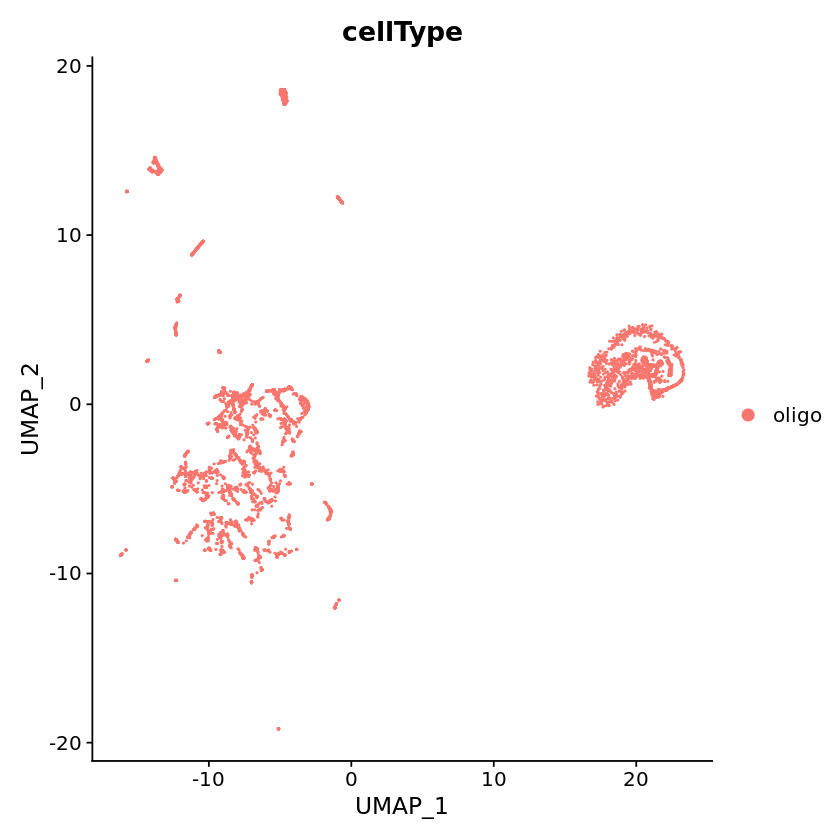

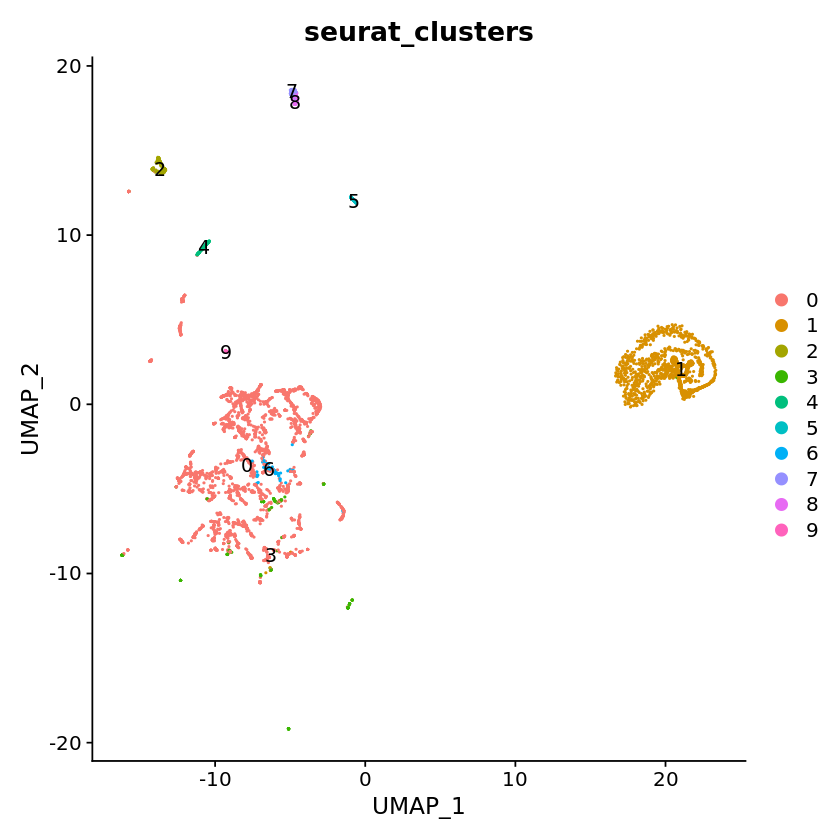

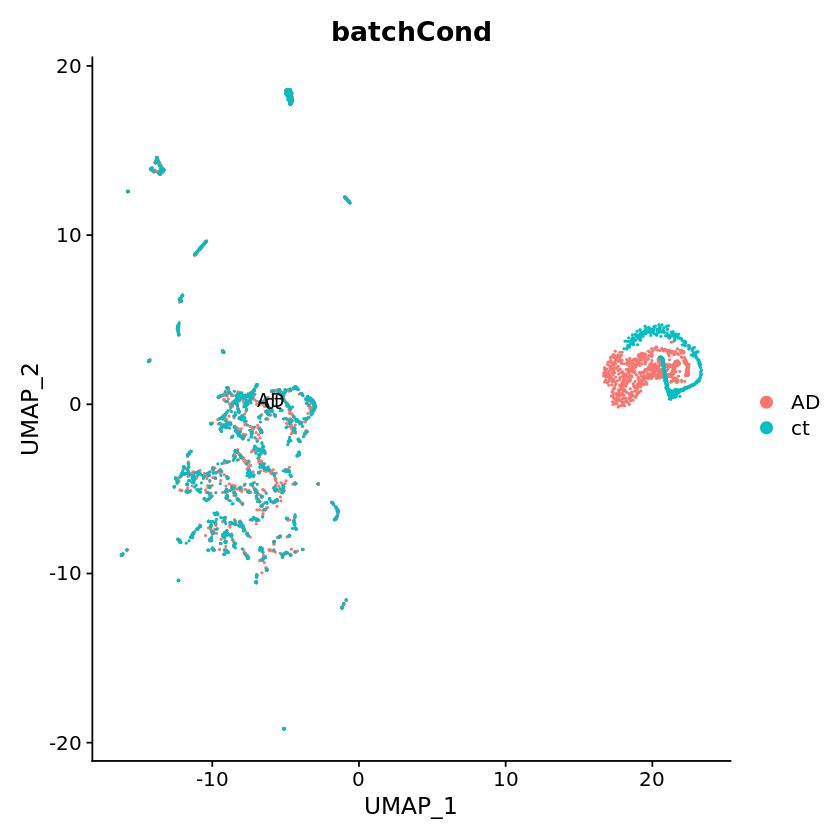

In [122]:
DimPlot(oligos_so_main_subclusters, reduction='umap', group.by='cellType')
DimPlot(oligos_so_main_subclusters, reduction='umap', group.by='seurat_clusters', label = T)
DimPlot(oligos_so_main_subclusters, reduction='umap', group.by='batchCond', label = T)

In [118]:
res.table <- DetectUTRLengthShift(peaks.object = oligos_so_main_subclusters, 
                                  gtf_gr = gtf_gr,
                                  gtf_TxDb = gtf_TxDb,
                                  population.1 = "0", 
                                  population.2 = "1")
PlotUTRLengthShift(res.table)

[1] "599 expressed peaks in feature types UTR3"
[1] "579 peaks after filtering out A-rich annotations"
[1] "88 genes detected with multiple peak sites expressed"
[1] "206 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in vst(exp(alleffects), object):
"Dispersion function not parametric, applying log2(x+ 1) instead of vst...
"


[1] "No DU peaks identified"


ERROR: Error in subset.default(results.table, FC_direction == "Up"): object 'FC_direction' not found


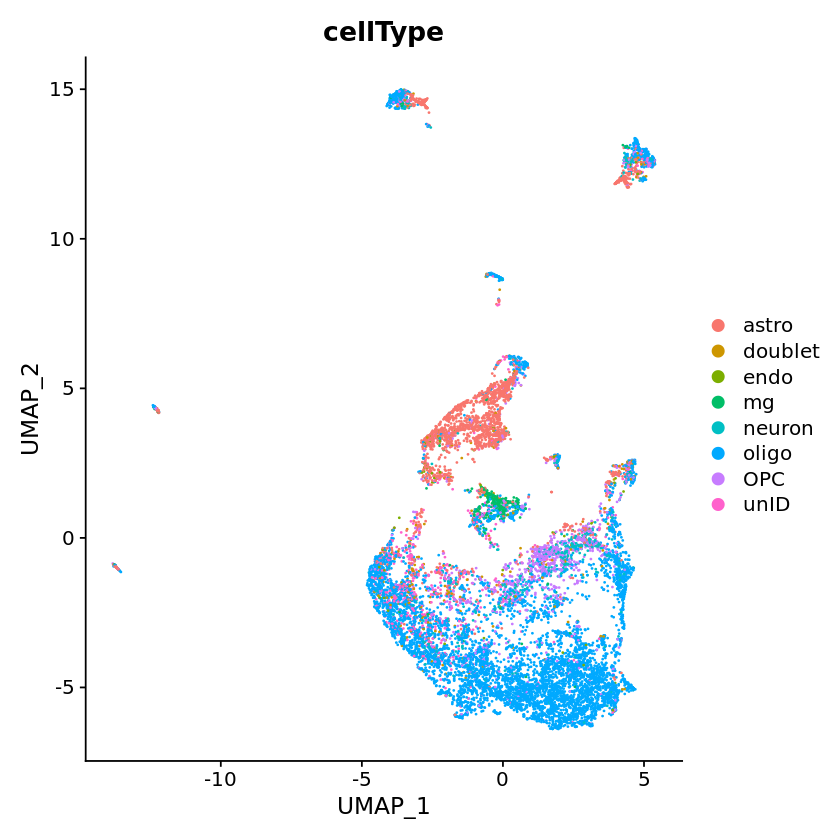

In [124]:
DimPlot(peaks_so, reduction='umap', group.by='cellType')


[1] "1171 expressed peaks in feature types UTR3"
[1] "1114 peaks after filtering out A-rich annotations"
[1] "174 genes detected with multiple peak sites expressed"
[1] "402 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in vst(exp(alleffects), object):
"Dispersion function not parametric, applying log2(x+ 1) instead of vst...
"


[1] "Detecting shifts in 3'UTR length usage"


Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 0.206652360767533"


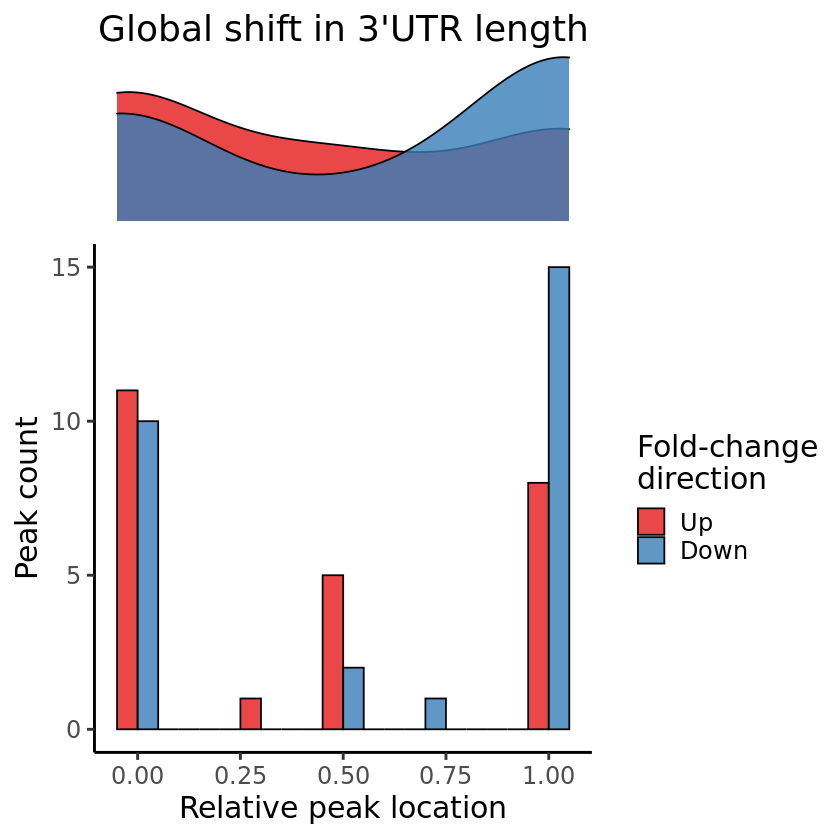

In [126]:
peaks_so <- SetIdent(peaks_so, value = "cellType")
res.table <- DetectUTRLengthShift(peaks.object = peaks_so, 
                                  gtf_gr = gtf_gr,
                                  gtf_TxDb = gtf_TxDb,
                                  population.1 = "astro", 
                                  population.2 = "oligo")
PlotUTRLengthShift(res.table)

[1] "1171 expressed peaks in feature types UTR3"
[1] "189 genes detected with multiple peak sites expressed"
[1] "446 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in vst(exp(alleffects), object):
"Dispersion function not parametric, applying log2(x+ 1) instead of vst...
"


[1] "Filtering for alternative transcript usage"
[1] "67 peaks detected as representing alternative transcript usage"


,gene_name,genomic_feature(s),population1_pct,population2_pct,pvalue,padj,Log2_fold_change,Transcript_name
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GFAP:chr17:44909645-44910083:-1,GFAP,UTR3,0.18405192,0.0254480777,9.433852e-72,4.207498e-69,1.8308837,ENST00000588735;ENST00000639277;ENST00000638304;ENST00000441312;ENST00000638488;ENST00000639369;ENST00000638400;ENST00000639042;ENST00000253408;ENST00000586125;ENST00000638618;ENST00000589701;ENST00000592706;ENST00000585543;ENST00000591880;ENST00000588640;ENST00000640552;ENST00000435360;ENST00000591327;ENST00000638281;ENST00000639921
GFAP:chr17:44905561-44906029:-1,GFAP,UTR3,0.42188224,0.2377890272,2.520725e-71,5.621216e-69,-0.2572219,ENST00000588735;ENST00000639277;ENST00000638304;ENST00000441312;ENST00000639243;ENST00000638488;ENST00000639369;ENST00000592065;ENST00000640859;ENST00000638400;ENST00000639042;ENST00000640545;ENST00000638921;ENST00000253408;ENST00000586125
LGI4:chr19:35124513-35124840:-1,LGI4,UTR3,0.20027816,0.0608838418,2.367067e-62,3.519039e-60,-1.1100801,ENST00000310123;ENST00000392225;ENST00000493050;ENST00000587780;ENST00000591840
HSP90AA1:chr14:102080995-102081499:-1,HSP90AA1,UTR3,0.18312471,0.2737720618,1.584834e-57,1.413672e-55,-0.7107686,ENST00000216281;ENST00000334701
HSP90AA1:chr14:102084797-102086048:-1,HSP90AA1,UTR3,0.16179879,0.1422903270,1.423187e-57,1.413672e-55,0.7685161,ENST00000216281;ENST00000334701;ENST00000554401;ENST00000560130;ENST00000553585;ENST00000555662;ENST00000556554;ENST00000557234
H3F3B:chr17:75777416-75777873:-1,H3F3B,UTR3,0.11219286,0.1524148310,1.214232e-56,9.025788e-55,-1.1464968,ENST00000254810
SLC1A2:chr11:35251205-35251484:-1,SLC1A2,UTR3,0.65878535,0.0753865098,4.503856e-55,2.869600e-53,-0.8279867,ENST00000278379;ENST00000642769
NCAM1:chr11:113278021-113278436:1,NCAM1,UTR3,0.12980992,0.0675879053,5.244605e-49,2.923868e-47,1.2340371,ENST00000615112;ENST00000615285;ENST00000618266;ENST00000316851
NCAM1:chr11:113264750-113265259:1,NCAM1,UTR3,0.07881317,0.1744424682,7.142101e-49,3.539308e-47,-0.9641672,ENST00000621518;ENST00000615112;ENST00000615285;ENST00000618266;ENST00000619839;ENST00000621128;ENST00000316851;ENST00000620046;ENST00000531044;ENST00000611284;ENST00000533073;ENST00000528590;ENST00000528158


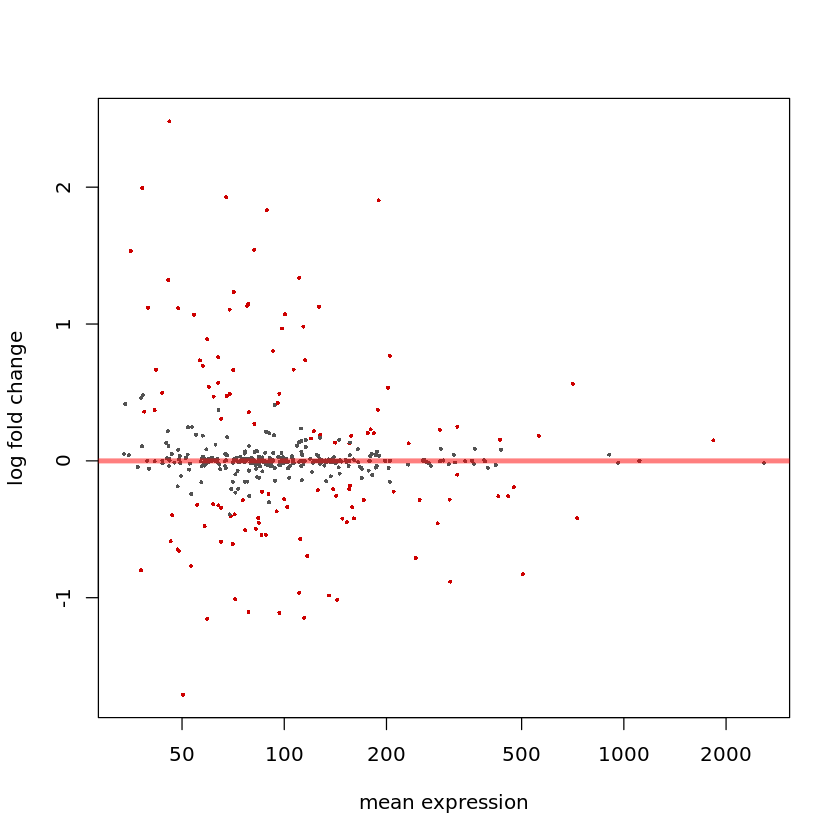

In [127]:
res.table <- DetectAEU(peaks.object = peaks_so, 
                       gtf_gr = gtf_gr,
                       gtf_TxDb = gtf_TxDb,
                       do.MAPlot = T,
                       population.1 = "astro", 
                       population.2 = "oligo")
res.table